In [1]:
import datetime
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
train = pd.read_csv("features.csv", index_col="match_id")

In [4]:
train.head()

,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
match_id,,,,,,,,,,,,,,,,,,,,,
0,1430198770,7,11,5,2098,1489,20,0,0,7,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1430220345,0,42,4,1188,1033,9,0,1,12,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,1430227081,7,33,4,1319,1270,22,0,0,12,...,4,3,1,13.0,2130,0,0,1830,0,63
3,1430263531,1,29,4,1779,1056,14,0,0,5,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,1430282290,7,13,4,1431,1090,8,1,0,8,...,3,3,0,-16.0,2449,0,4,1974,3,63


In [5]:
train.drop([
    "duration",
    "tower_status_radiant",
    "tower_status_dire",
    "barracks_status_radiant",
    "barracks_status_dire",
], axis=1, inplace=True)

In [10]:
count_na = len(train) - train.count()
count_na[count_na > 0].sort_values(ascending=False) / len(train)

first_blood_player2            0.452402
radiant_flying_courier_time    0.282619
dire_flying_courier_time       0.268415
first_blood_player1            0.201100
first_blood_team               0.201100
first_blood_time               0.201100
dire_bottle_time               0.166029
radiant_bottle_time            0.161380
radiant_first_ward_time        0.018883
dire_first_ward_time           0.018780
radiant_courier_time           0.007117
dire_courier_time              0.006953
dtype: float64

In [11]:
train.fillna(0, inplace=True)

In [12]:
X_train = train.drop("radiant_win", axis=1)
y_train = train["radiant_win"]

In [13]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
def score_gb(X, y):
    scores = {}

    for n_estimators in [10, 20, 30, 50, 100, 250]:
        print(f"n_estimators={n_estimators}")
        model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[n_estimators] = score
        print()
        
    return pd.Series(scores)

n_estimators=10
Score: 0.665
Time elapsed: 0:01:01.589290

n_estimators=20
Score: 0.682
Time elapsed: 0:02:04.433493

n_estimators=30
Score: 0.690
Time elapsed: 0:02:57.759966

n_estimators=50
Score: 0.697
Time elapsed: 0:04:55.190411

n_estimators=100
Score: 0.706
Time elapsed: 0:09:35.885076

n_estimators=250
Score: 0.716
Time elapsed: 0:25:24.738448



<AxesSubplot:>

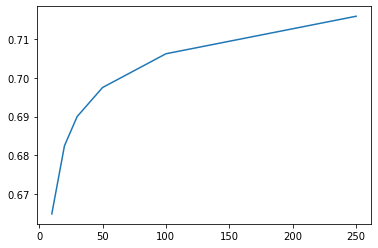

In [15]:
scores = score_gb(X_train, y_train)
scores.plot()

In [16]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

In [17]:
def score_lr(X, y):
    scores = {}

    for i in range(-5, 6):
        C = 10.0 ** i

        print(f"C={C}")
        model = LogisticRegression(C=C, random_state=42)

        start_time = datetime.datetime.now()
        score = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
        print(f"Score: {score:.3f}")
        print(f"Time elapsed: {datetime.datetime.now() - start_time}")

        scores[i] = score
        print()

    return pd.Series(scores)

C=1e-05
Score: 0.695
Time elapsed: 0:00:03.931663

C=0.0001
Score: 0.711
Time elapsed: 0:00:02.842812

C=0.001
Score: 0.716
Time elapsed: 0:00:04.492251

C=0.01
Score: 0.717
Time elapsed: 0:00:06.400464

C=0.1
Score: 0.717
Time elapsed: 0:00:06.197924

C=1.0
Score: 0.717
Time elapsed: 0:00:06.892218

C=10.0
Score: 0.717
Time elapsed: 0:00:06.264424

C=100.0
Score: 0.717
Time elapsed: 0:00:05.987510

C=1000.0
Score: 0.717
Time elapsed: 0:00:06.089249

C=10000.0
Score: 0.717
Time elapsed: 0:00:06.028060

C=100000.0
Score: 0.717
Time elapsed: 0:00:05.975785



<AxesSubplot:>

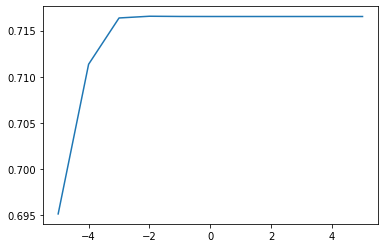

In [18]:
scores = score_lr(X_train, y_train)
scores.plot()

In [19]:
def print_best_lr_score(scores: pd.Series):
    best_iteration = scores.sort_values(ascending=False).head(1)
    best_C = 10.0 ** best_iteration.index[0]
    best_score = best_iteration.values[0]

    print(f"Наилучшее значение показателя AUC-ROC достигается при C = {best_C:.2f} и равно {best_score:.2f}.")

In [20]:
hero_columns = [f"r{i}_hero" for i in range (1, 6)] + [f"d{i}_hero" for i in range (1, 6)]
cat_columns = ["lobby_type"] + hero_columns
X_train.drop(cat_columns, axis=1, inplace=True)

C=1e-05
Score: 0.695
Time elapsed: 0:00:02.153244

C=0.0001
Score: 0.711
Time elapsed: 0:00:02.640176

C=0.001
Score: 0.716
Time elapsed: 0:00:04.129847

C=0.01
Score: 0.717
Time elapsed: 0:00:05.453486

C=0.1
Score: 0.717
Time elapsed: 0:00:05.507838

C=1.0
Score: 0.717
Time elapsed: 0:00:05.426124

C=10.0
Score: 0.717
Time elapsed: 0:00:05.349039

C=100.0
Score: 0.717
Time elapsed: 0:00:05.681639

C=1000.0
Score: 0.717
Time elapsed: 0:00:05.957967

C=10000.0
Score: 0.717
Time elapsed: 0:00:06.040755

C=100000.0
Score: 0.717
Time elapsed: 0:00:06.010574



<AxesSubplot:>

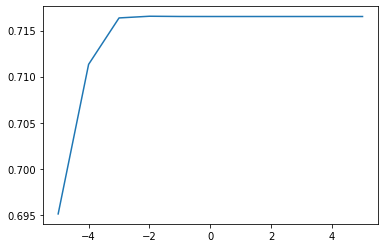

In [21]:
scores = score_lr(X_train, y_train)
scores.plot()

In [22]:

print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.01 и равно 0.72.


In [23]:
unique_heroes = np.unique(train[hero_columns].values.ravel())
N = max(unique_heroes)
print(f"Число уникальных героев в train: {len(unique_heroes)}. Максимальный ID героя: {N}.")

Число уникальных героев в train: 108. Максимальный ID героя: 112.


In [24]:
def get_pick(data):
    X_pick = np.zeros((data.shape[0], N))

    for i, match_id in enumerate(data.index):
        for p in range(1, 6):
            X_pick[i, data.loc[match_id, f"r{p}_hero"] - 1] = 1
            X_pick[i, data.loc[match_id, f"d{p}_hero"] - 1] = -1

    return pd.DataFrame(X_pick, index=data.index, columns=[f"hero_{i}" for i in range(N)])


In [25]:
X_pick = get_pick(train)
X_pick.head()

,hero_0,hero_1,hero_2,hero_3,hero_4,hero_5,hero_6,hero_7,hero_8,hero_9,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
X_train = pd.concat([X_train, X_pick], axis=1)

C=1e-05
Score: 0.699
Time elapsed: 0:00:06.097265

C=0.0001
Score: 0.725
Time elapsed: 0:00:06.849697

C=0.001
Score: 0.746
Time elapsed: 0:00:10.808025

C=0.01
Score: 0.752
Time elapsed: 0:00:17.542553

C=0.1
Score: 0.752
Time elapsed: 0:00:21.433574

C=1.0
Score: 0.752
Time elapsed: 0:00:21.731056

C=10.0
Score: 0.752
Time elapsed: 0:00:21.534910

C=100.0
Score: 0.752
Time elapsed: 0:00:23.421177

C=1000.0
Score: 0.752
Time elapsed: 0:00:23.516528

C=10000.0
Score: 0.752
Time elapsed: 0:00:22.244805

C=100000.0
Score: 0.752
Time elapsed: 0:00:22.574277



<AxesSubplot:>

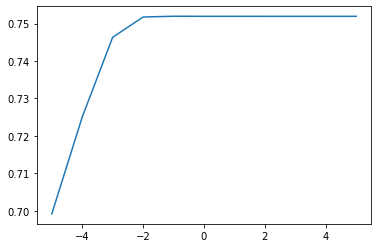

In [27]:
scores = score_lr(X_train, y_train)
scores.plot()

In [28]:
print_best_lr_score(scores)

Наилучшее значение показателя AUC-ROC достигается при C = 0.10 и равно 0.75.


In [34]:
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train, y_train)

/home/yalokinz/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=0.1, random_state=42)

In [35]:
test = pd.read_csv("features_test.csv", index_col="match_id")
test.fillna(0, inplace=True)

In [36]:
X_test = pd.DataFrame(scaler.transform(test), index=test.index, columns=test.columns)
X_test.drop(cat_columns, axis=1, inplace=True)
X_test = pd.concat([X_test, get_pick(test)], axis=1)
X_test.head()

,start_time,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
6,-2.528200,0.501314,-0.230161,-0.126909,-0.357459,-0.537757,1.017574,0.291758,-0.332256,-0.011207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-2.527214,-1.297676,-1.195592,-1.245180,-1.131661,-0.537757,-0.578083,0.291758,0.578881,0.008600,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,-2.525688,-1.297676,-0.851426,-0.732370,-1.131661,-0.537757,-0.578083,1.893320,-1.243393,-1.383288,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13,-2.521671,-0.398181,-0.927319,-0.527677,-1.131661,0.968527,1.017574,1.092539,-1.243393,-0.931329,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0
16,-2.520369,0.501314,0.045173,-1.049106,-0.799860,-0.537757,-0.578083,0.291758,1.490017,0.925122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
preds = pd.Series(model.predict_proba(X_test)[:, 1])
preds.describe()

count    17177.000000
mean         0.517031
std          0.220963
min          0.008432
25%          0.346091
50%          0.522135
75%          0.691758
max          0.996372
dtype: float64

<AxesSubplot:ylabel='Frequency'>

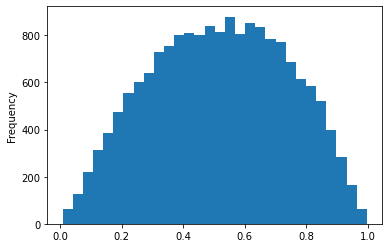

In [38]:
preds.plot.hist(bins=30)